# Ensemble tide model tide guage validation

This code compares tides modelled using custom ensemble tide modelling against results from various other global ocean tide models at [Global Extreme Sea Level Analysis (GESLA) tide gauges](https://gesla787883612.wordpress.com/) across Australia.

> Haigh, I.D., Marcos, M., Talke, S.A., Woodworth, P.L., Hunter, J.R., Hague, B.S., Arns, A., Bradshaw, E. and Thompson, P., 2023. GESLA version 3: A major update to the global higher‐frequency sea‐level dataset. Geoscience Data Journal, 10(3), pp.293-314.

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [2]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages:

In [3]:
!pip install -e /home/jovyan/Robbi/dea-notebooks/Tools/

Obtaining file:///home/jovyan/Robbi/dea-notebooks/Tools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dea-tools (pyproject.toml) ... done
  Created wheel for dea-tools: filename=dea_tools-0.3.4.dev42-0.editable-py3-none-any.whl size=9304 sha256=769901606dccddbb83ec556ad090481ad03049cb289bf18bca47c7bb8f139acd
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxhxk6wi/wheels/af/2a/40/01ca258065e7dc1e8ff8e4c4988d8f96fc4bdf33d859c929eb
Successfully built dea-tools
  Attempting uninstall: dea-tools
    Found existing installation: dea-tools 0.3.2
    Uninstalling dea-tools-0.3.2:
      Successfully uninstalled dea-tools-0.3.2


In [4]:
!pip install git+https://github.com/tsutterley/pyTMD.git

  Cloning https://github.com/tsutterley/pyTMD.git to /tmp/pip-req-build-c61qs497
  Running command git clone --filter=blob:none --quiet https://github.com/tsutterley/pyTMD.git /tmp/pip-req-build-c61qs497
  Resolved https://github.com/tsutterley/pyTMD.git to commit 10bdc56c0867a970684e09398a57bf2f0cd8acf5
  Preparing metadata (setup.py) ... done
  Using cached timescale-0.0.4-py3-none-any.whl.metadata (3.7 kB)
Using cached timescale-0.0.4-py3-none-any.whl (1.2 MB)
  Created wheel for pyTMD: filename=pyTMD-2.1.3.dev1+g10bdc56-py3-none-any.whl size=6397989 sha256=dfa012dd8a4345bf30497f629dd68de39856b3d2be022a882e492642d7f1b887
  Stored in directory: /tmp/pip-ephem-wheel-cache-88d3jf1b/wheels/58/b8/f7/dccb6c539ec5f0ff6f8bcd8fe751abe41d8a5e9c002ed0856f
Successfully built pyTMD
  Attempting uninstall: pyTMD
    Found existing installation: pyTMD 2.1.0
    Uninstalling pyTMD-2.1.0:
      Successfully uninstalled pyTMD-2.1.0


### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import warnings
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from odc.geo.geom import BoundingBox

from dea_tools.validation import eval_metrics
from intertidal.utils import round_date_strings

os.environ["DEA_TOOLS_TIDE_MODELS"] = "/gdata1/data/tide_models_clipped"

In [3]:

def _load_gauge_metadata(metadata_path):
    
    # Load metadata
    metadata_df = pd.read_csv(metadata_path)
    metadata_df.columns = (
        metadata_df.columns.str.replace(" ", "_", regex=False)
        .str.replace("(", "", regex=False)
        .str.replace(")", "", regex=False)
        .str.replace("/", "_", regex=False)
        .str.lower()
    )
    metadata_df = metadata_df.set_index("site_code")

    # Convert metadata to GeoDataFrame
    metadata_gdf = gpd.GeoDataFrame(
        data=metadata_df,
        geometry=gpd.points_from_xy(metadata_df.longitude, metadata_df.latitude),
        crs="EPSG:4326",
    )
    
    return metadata_df, metadata_gdf


def tide_gauge_abslmp(
    x=None,
    y=None,
    site_code=None,
    time=("2020", "2021"),
    ahd=True,
    site_metadata=True,
    data_path="/gdata1/data/sea_level/abslmp/",
    metadata_path="/gdata1/data/sea_level/ABSLMP_station_metadata_v2.csv",
):
    """
    Load and process Australian Baseline Sea Level Monitoring Program
    (ABSLMP) tide gauge data.

    Parameters
    ----------
    x, y : tuple, optional
        Tuples defining the x and y bounding box within which to load
        tide gauge data, in WGS84 (degrees latitude, longitude) units.
        Leave as None if providing a list of site codes using 'site_code'.
    site_code : str or list of str, optional
        ABSLMP site code(s) for which to load data. If provided, 'x' and
        'y' will be ignored.
    time : tuple or list of str, optional
        Time range to consider, given as a tuple of start and end years.
        If None, will default to all tide observations from 1991 onward.
        Default is ("2020", "2021").
    ahd : bool, optional
        Whether to correct sea level to Australian Height Datum (AHD).
        Default is True.
    site_metadata : bool, optional
        Whether to add tide gauge station metadata as additional columns
        in the output DataFrame. Defaults to True.
    data_path : str, optional
        Path to the raw ABSLMP data files. Default is
        "/gdata1/data/sea_level/abslmp/".
    metadata_path : str, optional
        Path to the ABSLMP station metadata file.
        Default is "/gdata1/data/sea_level/ABSLMP_station_metadata_v2.csv".

    Returns
    -------
    pd.DataFrame
        Processed ABSLMP data as a DataFrame with columns including:
        "time": Timestamps,
        "sea_level": Observed sea level (m),
        "residuals": Residuals data (m),
        and additional columns from station metadata.
    """

    def _load_abslmp_dataset(path, na_value):
        abslmp_df = (
            pd.read_csv(
                path,
                parse_dates=[" Date & UTC Time"],
                na_values=na_value,
                usecols=[" Date & UTC Time", "Sea Level", "Residuals"],
            )
            .rename(
                {
                    " Date & UTC Time": "time",
                    "Sea Level": "sea_level",
                    "Residuals": "residuals",
                },
                axis=1,
            )
            .assign(site_code=path[-17:-9])
            .set_index("time")
        )

        return abslmp_df

    # Load tide gauge metadata
    metadata_df, metadata_gdf = _load_gauge_metadata(metadata_path)

    # Use supplied site codes if available
    if site_code is not None:
        site_code = [site_code] if isinstance(site_code, str) else site_code

    # Otherwise, use xy bounds to identify sites
    elif x is not None:
        bbox = BoundingBox.from_xy(x, y)
        site_code = metadata_gdf.cx[
            bbox.left : bbox.right, bbox.top : bbox.bottom
        ].index

    # Otherwise, return all available site codes
    else:
        site_code = metadata_df.index.to_list()

    # Prepare times
    if time is None:
        time = ["1991", str(datetime.datetime.now().year)]
    time = [time] if isinstance(time, str) else time
    start_time = round_date_strings(time[0], round_type="start")
    end_time = round_date_strings(time[-1], round_type="end")

    # Identify paths to load and nodata values for each site
    years = list(range(int(start_time[0:4]), int(end_time[0:4]) + 1))
    paths_na = [
        (glob.glob(f"{data_path}/{s}_*{y}.csv"), metadata_df.loc[s].null_value)
        for y in years
        for s in site_code
    ]

    # Expand so we have a nodata value for each path, then load and
    # combine into a single dataframe
    paths_na = [(path, na) for paths, na in paths_na for path in paths]
    data_df = (
        pd.concat([_load_abslmp_dataset(path, na_value=na) for path, na in paths_na])
        .loc[slice(start_time, end_time)]
        .reset_index()
        .set_index("site_code")
    )

    # Insert metadata into dataframe
    data_df[metadata_df.columns] = metadata_df

    # Add time to index and remove duplicates
    data_df = data_df.set_index("time", append=True)
    duplicates = data_df.index.duplicated()
    if duplicates.sum() > 0:
        warnings.warn("Duplicate timestamps were removed.")
        data_df = data_df.loc[~duplicates]

    # Correct to AHD (i.e. mean sea level)
    if ahd:
        data_df["sea_level"] -= data_df.ahd

    # Return data
    if not site_metadata:
        return data_df[["sea_level", "residuals"]]
    else:
        return data_df


from tqdm import tqdm
    
    
def tide_gauge_gesla(
    x=None,
    y=None,
    site_code=None,
    time=("2020", "2021"),
    filter_use_flag=True,
    site_metadata=True,
    data_path="/gdata1/data/sea_level/gesla/",
    metadata_path="/gdata1/data/sea_level/GESLA3_ALL 2.csv",
):
    """
    Load and process Global Extreme Sea Level Analysis (GESLA) tide
    gauge data.

    Modified from original code from https://github.com/philiprt/GeslaDataset.

    Parameters
    ----------
    x, y : tuple, optional
        Tuples defining the x and y bounding box within which to load
        tide gauge data, in WGS84 (degrees latitude, longitude) units.
        Leave as None if providing a list of site codes using 'site_code'.
    site_code : str or list of str, optional
        GESLA site code(s) for which to load data. If provided, 'x' and
        'y' will be ignored.
    time : tuple or list of str, optional
        Time range to consider, given as a tuple of start and end years.
        If None, will default to all tide observations from 1800 onward.
        Default is ("2020", "2021").
    filter_use_flag : bool, optional
        Whether to filter out low quality observations with a "use_flag"
        value of 0 (do not use). Defaults to True.
    site_metadata : bool, optional
        Whether to add tide gauge station metadata as additional columns
        in the output DataFrame. Defaults to True.
    data_path : str, optional
        Path to the raw GESLA data files. Default is
        "/gdata1/data/sea_level/gesla/".
    metadata_path : str, optional
        Path to the GESLA station metadata file.
        Default is "/gdata1/data/sea_level/GESLA3_ALL 2.csv".

    Returns
    -------
    pd.DataFrame
        Processed GESLA data as a DataFrame with columns including:
        "time": Timestamps,
        "sea_level": Observed sea level (m),
        "qc_flag": Observed sea level QC flag,
        "use_flag": Use-in-analysis flag (1 = use, 0 = do not use),
        and additional columns from station metadata.
    """

    def _load_gesla_dataset(site, path, na_value):
        gesla_df = (
            pd.read_csv(
                path,
                skiprows=41,
                names=["date_in", "time_in", "sea_level", "qc_flag", "use_flag"],
                sep="\s+",
                na_values=na_value,
            )
            .assign(
                time=lambda df: pd.to_datetime(df["date_in"] + " " + df["time_in"]),
                site_code=site,
            )
            .set_index("time")
            .drop(["date_in", "time_in"], axis=1)
        )
        
        print(path)

        return gesla_df

    
    # Load tide gauge metadata
    metadata_df, metadata_gdf = _load_gauge_metadata(metadata_path)    

    # Use supplied site codes if available
    if site_code is not None:
        site_code = [site_code] if isinstance(site_code, str) else site_code

    # Otherwise, use xy bounds to identify sites
    elif x is not None:
        bbox = BoundingBox.from_xy(x, y)
        site_code = metadata_gdf.cx[
            bbox.left : bbox.right, bbox.top : bbox.bottom
        ].index

    # Otherwise, return all available site codes
    else:
        site_code = metadata_df.index.to_list()

    # Prepare times
    if time is None:
        time = ["1800", str(datetime.datetime.now().year)]
    time = [time] if isinstance(time, str) else time
    start_time = round_date_strings(time[0], round_type="start")
    end_time = round_date_strings(time[-1], round_type="end")

    # Identify paths to load and nodata values for each site
    metadata_df["file_name"] = data_path + metadata_df["file_name"]
    paths_na = metadata_df.loc[site_code, ["file_name", "null_value"]]

    # Load and combine into a single dataframe
    data_df = (
        pd.concat(
            [
                _load_gesla_dataset(s, p, na_value=na)
                for s, p, na in paths_na.itertuples()
            ]
        )
        .sort_index()
        .loc[slice(start_time, end_time)]
        .reset_index()
        .set_index("site_code")
    )

    # Optionally filter by use flag column
    if filter_use_flag:
        data_df = data_df.loc[data_df.use_flag == 1]

    # Optionally insert metadata into dataframe
    if site_metadata:
        data_df[metadata_df.columns] = metadata_df.loc[site_code]

    # Add time to index and remove duplicates
    data_df = data_df.set_index("time", append=True)
    duplicates = data_df.index.duplicated()
    if duplicates.sum() > 0:
        warnings.warn("Duplicate timestamps were removed.")
        data_df = data_df.loc[~duplicates]

    # Return data
    return data_df


# tide_gauge_abslmp(x=(140, 160), y=(-30, -35))
# tide_gauge_gesla(x=(140, 160), y=(-30, -35))

### GESLA tide guage data


In [ ]:
# # Load tide gauge metadata
# metadata_df, metadata_gdf = _load_gauge_metadata(metadata_path="/gdata1/data/sea_level/GESLA3_ALL 2.csv") 
# metadata_gdf.to_file("gesla_stations.geojson")

In [4]:
# Load Collection 3 summary grid
c3_path = "https://data.dea.ga.gov.au/derivative/ga_summary_grid_c3.geojson"
c3_grid = gpd.read_file(c3_path)
xmin, ymin, xmax, ymax = c3_grid.total_bounds

In [20]:
# Extract tide data for all sites
gauge_df = tide_gauge_gesla(x=(xmin, xmax), y=(ymax, ymin), time=("2017", "2019"))

/gdata1/data/sea_level/gesla/fort_denison-333a-aus-uhslc
/gdata1/data/sea_level/gesla/townsville-334a-aus-uhslc
/gdata1/data/sea_level/gesla/bundaberg-332a-aus-uhslc
/gdata1/data/sea_level/gesla/brisbane-331a-aus-uhslc
/gdata1/data/sea_level/gesla/darwin-168a-aus-uhslc
/gdata1/data/sea_level/gesla/port_hedland-169a-aus-uhslc
/gdata1/data/sea_level/gesla/wyndham-165a-aus-uhslc
/gdata1/data/sea_level/gesla/esperance-176a-aus-uhslc
/gdata1/data/sea_level/gesla/spring_bay-335a-aus-uhslc
/gdata1/data/sea_level/gesla/carnarvon-167a-aus-uhslc
/gdata1/data/sea_level/gesla/fremantle-175a-aus-uhslc
/gdata1/data/sea_level/gesla/broome-166a-aus-uhslc
/gdata1/data/sea_level/gesla/hobart-339a-aus-uhslc
/gdata1/data/sea_level/gesla/booby_island-336a-aus-uhslc
/gdata1/data/sea_level/gesla/portland_victoria-129a-aus-uhslc
/gdata1/data/sea_level/gesla/port_kembla-342a-aus-uhslc
/gdata1/data/sea_level/gesla/cape_ferguson-343a-aus-uhslc
/gdata1/data/sea_level/gesla/hillarys-132a-aus-uhslc
/gdata1/data/sea

In [21]:
# Clean to restrict to Australia and remove duplicate sites/contributers
bad_sites = ("H033007A",  # Cape Ferguson, duplicate
             "H057022B",  # Thursday Island, duplicate
             "PLPEE01",  # Peel Inlet, inland
             "DVHAR01", # Harvey, inland
             "H060010A") # Half Tide Tug, duplicate 
bad_contributers = ("UHSLC",)
gauge_df = gauge_df.query(
    f"(country == 'AUS') & "
    f"(site_code not in {bad_sites}) & "
    f"(contributor_abbreviated not in {bad_contributers})"
)

# Normalise to mean sea level
gauge_df["sea_level"] -= gauge_df.groupby(["site_code"])["sea_level"].transform("mean")

# Select 3-hourly subset
# gauge_df = gauge_df.iloc[::3]

In [22]:
# Export stations being processed to file
sites_df = gauge_df.groupby("site_code").first().iloc[:, 3:]
sites_gdf = gpd.GeoDataFrame(data=sites_df, geometry=gpd.points_from_xy(sites_df.longitude, sites_df.latitude))
sites_gdf.to_file("gesla_stations_aus.geojson")

## Model tides at each gauge

In [49]:
from dea_tools.coastal import model_tides

ensemble_funcs = {
    "ensemble-top": lambda x: x["rank"] == 1,
    "ensemble-bottom": lambda x: x["rank"] == 7,
    "ensemble-mean-top3": lambda x: x["rank"] <= 3,
    "ensemble-mean": lambda x: x["rank"] <= 7,
    # "ensemble-mean-top5": lambda x: x["rank"] <= 5,
    # "ensemble-mean-weighted": lambda x: 8 - x["rank"],
}

tide_df = model_tides(
    x=gauge_df.longitude,  #.iloc[0:5],
    y=gauge_df.latitude,  #.iloc[0:5],
    time=gauge_df.index.get_level_values("time"),  #[0:5],
    model=[
        "FES2014",
        "FES2012",
        "TPXO8-atlas-v1",
        "TPXO9-atlas-v5",
        "EOT20",
        "HAMTIDE11",
        "GOT4.10",
        "ensemble",
    ],
    mode="one-to-one",
    parallel_splits=50,
    output_format="wide",
    ensemble_func=ensemble_funcs,
    p=2,
).rename(
    {
        "TPXO9-atlas-v5": "TPXO9",
        "TPXO8-atlas": "TPXO8",
        "TPXO8-atlas-v1": "TPXO8",
    },
    axis=1,
)
tide_df

Running ensemble tide modelling
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 350/350 [02:52<00:00,  2.03it/s]


Interpolating model rankings using IDW interpolation {'p': 2}
Combining models into single ensemble-top model
Combining models into single ensemble-bottom model
Combining models into single ensemble-mean-top3 model
Combining models into single ensemble-mean model
Converting to a wide format dataframe


tide_model                           EOT20   FES2012   FES2014   GOT4.10  \
time       x          y                                                    
2017-01-01 152.508211 -32.173989  0.784791  0.850682  0.825635  0.799521   
           147.973100 -37.885200  0.545370  0.561856  0.587374  0.545110   
           150.476500 -35.357700  0.726228  0.761144  0.737824  0.717146   
           146.833300 -19.250000  0.971019  1.029977  1.020217  1.012640   
           147.341000 -42.877300  0.371824  0.435218  0.405258  0.403980   
...                                    ...       ...       ...       ...   
2019-12-31 150.759200 -34.906600  0.470200  0.502368  0.490144  0.475990   
           151.220400 -33.968400  0.448499  0.515940  0.504787  0.490595   
           121.895400 -33.870900 -0.256765 -0.189922 -0.202952 -0.193056   
           115.629983 -32.601376 -0.261014 -0.195017 -0.206508 -0.219800   
           135.870100 -34.715900 -0.402618 -0.342923 -0.321599 -0.230691   

tide_model                        HAMTIDE11     TPXO8     TPXO9  \
time       x          y                                           
2017-01-01 152.508211 -32.173989   0.837228  0.835900  0.817941   
           147.973100 -37.885200   0.539387  0.506428  0.469878   
           150.476500 -35.357700   0.741500  0.723237  0.722399   
           146.833300 -19.250000   1.075376  0.919476  1.036068   
           147.341000 -42.877300   0.397241  0.375177  0.392107   
...                                     ...       ...       ...   
2019-12-31 150.759200 -34.906600   0.499208  0.481597  0.492294   
           151.220400 -33.968400   0.512284  0.476872  0.507859   
           121.895400 -33.870900  -0.166687 -0.181433 -0.178121   
           115.629983 -32.601376  -0.195348 -0.176052 -0.029747   
           135.870100 -34.715900  -0.297189 -0.254946 -0.258349   

tide_model                        ensemble-bottom  ensemble-mean  \
time       x          y                                            
2017-01-01 152.508211 -32.173989         0.837228       0.821671   
           147.973100 -37.885200         0.561856       0.536486   
           150.476500 -35.357700         0.761144       0.732783   
           146.833300 -19.250000         1.012640       1.009253   
           147.341000 -42.877300         0.435218       0.397258   
...                                           ...            ...   
2019-12-31 150.759200 -34.906600         0.502368       0.487400   
           151.220400 -33.968400         0.515940       0.493834   
           121.895400 -33.870900        -0.181433      -0.195562   
           115.629983 -32.601376        -0.195017      -0.183355   
           135.870100 -34.715900        -0.230691      -0.301188   

tide_model                        ensemble-mean-top3  ensemble-top  
time       x          y                                             
2017-01-01 152.508211 -32.173989            0.814366      0.799521  
           147.973100 -37.885200            0.507225      0.545370  
           150.476500 -35.357700            0.722203      0.726228  
           146.833300 -19.250000            0.975521      0.919476  
           147.341000 -42.877300            0.389730      0.371824  
...                                              ...           ...  
2019-12-31 150.759200 -34.906600            0.483668      0.470200  
           151.220400 -33.968400            0.481293      0.448499  
           121.895400 -33.870900           -0.212613     -0.256765  
           115.629983 -32.601376           -0.218955     -0.261014  
           135.870100 -34.715900           -0.278298     -0.258349  

[5337216 rows x 11 columns]

In [50]:
tide_df_fes2022 = model_tides(
    x=gauge_df.longitude,  #.iloc[0:5],
    y=gauge_df.latitude,  #.iloc[0:5],
    time=gauge_df.index.get_level_values("time"),  #[0:5],
    model=[
        "FES2022",
    ],
    mode="one-to-one",
    parallel_splits=10,
    output_format="wide",
    ensemble_func=ensemble_funcs,
    p=2,
)

tide_df["FES2022"] = tide_df_fes2022.FES2022
tide_df

Modelling tides using FES2022 in parallel


100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


Converting to a wide format dataframe


tide_model                           EOT20   FES2012   FES2014   GOT4.10  \
time       x          y                                                    
2017-01-01 152.508211 -32.173989  0.784791  0.850682  0.825635  0.799521   
           147.973100 -37.885200  0.545370  0.561856  0.587374  0.545110   
           150.476500 -35.357700  0.726228  0.761144  0.737824  0.717146   
           146.833300 -19.250000  0.971019  1.029977  1.020217  1.012640   
           147.341000 -42.877300  0.371824  0.435218  0.405258  0.403980   
...                                    ...       ...       ...       ...   
2019-12-31 150.759200 -34.906600  0.470200  0.502368  0.490144  0.475990   
           151.220400 -33.968400  0.448499  0.515940  0.504787  0.490595   
           121.895400 -33.870900 -0.256765 -0.189922 -0.202952 -0.193056   
           115.629983 -32.601376 -0.261014 -0.195017 -0.206508 -0.219800   
           135.870100 -34.715900 -0.402618 -0.342923 -0.321599 -0.230691   

tide_model                        HAMTIDE11     TPXO8     TPXO9  \
time       x          y                                           
2017-01-01 152.508211 -32.173989   0.837228  0.835900  0.817941   
           147.973100 -37.885200   0.539387  0.506428  0.469878   
           150.476500 -35.357700   0.741500  0.723237  0.722399   
           146.833300 -19.250000   1.075376  0.919476  1.036068   
           147.341000 -42.877300   0.397241  0.375177  0.392107   
...                                     ...       ...       ...   
2019-12-31 150.759200 -34.906600   0.499208  0.481597  0.492294   
           151.220400 -33.968400   0.512284  0.476872  0.507859   
           121.895400 -33.870900  -0.166687 -0.181433 -0.178121   
           115.629983 -32.601376  -0.195348 -0.176052 -0.029747   
           135.870100 -34.715900  -0.297189 -0.254946 -0.258349   

tide_model                        ensemble-bottom  ensemble-mean  \
time       x          y                                            
2017-01-01 152.508211 -32.173989         0.837228       0.821671   
           147.973100 -37.885200         0.561856       0.536486   
           150.476500 -35.357700         0.761144       0.732783   
           146.833300 -19.250000         1.012640       1.009253   
           147.341000 -42.877300         0.435218       0.397258   
...                                           ...            ...   
2019-12-31 150.759200 -34.906600         0.502368       0.487400   
           151.220400 -33.968400         0.515940       0.493834   
           121.895400 -33.870900        -0.181433      -0.195562   
           115.629983 -32.601376        -0.195017      -0.183355   
           135.870100 -34.715900        -0.230691      -0.301188   

tide_model                        ensemble-mean-top3  ensemble-top   FES2022  
time       x          y                                                       
2017-01-01 152.508211 -32.173989            0.814366      0.799521  0.826815  
           147.973100 -37.885200            0.507225      0.545370  0.559241  
           150.476500 -35.357700            0.722203      0.726228  0.732498  
           146.833300 -19.250000            0.975521      0.919476  1.090615  
           147.341000 -42.877300            0.389730      0.371824  0.422864  
...                                              ...           ...       ...  
2019-12-31 150.759200 -34.906600            0.483668      0.470200  0.486642  
           151.220400 -33.968400            0.481293      0.448499  0.499314  
           121.895400 -33.870900           -0.212613     -0.256765 -0.202358  
           115.629983 -32.601376           -0.218955     -0.261014 -0.203080  
           135.870100 -34.715900           -0.278298     -0.258349 -0.333022  

[5337216 rows x 12 columns]

Pre-process into long format:

In [51]:
# Add tide gauge data to dataframe
tide_df["site_code"] = gauge_df.index.get_level_values("site_code").values
tide_df["site_name"] = gauge_df.site_name.values
tide_df["tide_gauge"] = gauge_df.sea_level.values

# Reshape to long format
tide_df_long = tide_df.melt(
    ignore_index=False,
    id_vars=["tide_gauge", "site_code", "site_name"],
    value_vars=[
        "FES2022",
        "FES2014",
        "FES2012",
        "TPXO8",
        "TPXO9",
        "EOT20",
        "HAMTIDE11",
        "GOT4.10",
        "ensemble-top",
        "ensemble-bottom",
        "ensemble-mean-top3",
        "ensemble-mean",
        # "ensemble-mean-top5",
        # "ensemble-mean-weighted",
    ],
    value_name="tide_m",
)

tide_df_long

tide_gauge site_code  \
time       x          y                                  
2017-01-01 152.508211 -32.173989    0.702968    209402   
           147.973100 -37.885200    0.423943     6057a   
           150.476500 -35.357700    0.730486    216471   
           146.833300 -19.250000    0.980192     59250   
           147.341000 -42.877300    0.436934     61220   
...                                      ...       ...   
2019-12-31 150.759200 -34.906600    0.354471    215408   
           151.220400 -33.968400    0.410569     60390   
           121.895400 -33.870900   -0.243620     62080   
           115.629983 -32.601376   -0.332215   DVBVD01   
           135.870100 -34.715900   -0.289914     61900   

                                                            site_name  \
time       x          y                                                 
2017-01-01 152.508211 -32.173989                              Forster   
           147.973100 -37.885200  Lakes_Entrance_Inner_Bullock_Island   
           150.476500 -35.357700                            Ulladulla   
           146.833300 -19.250000                           Townsville   
           147.341000 -42.877300                               Hobart   
...                                                               ...   
2019-12-31 150.759200 -34.906600                     Crookhaven_Heads   
           151.220400 -33.968400                           Botany_Bay   
           121.895400 -33.870900                            Esperance   
           115.629983 -32.601376                         Cape_Bouvard   
           135.870100 -34.715900                         Port_Lincoln   

                                     tide_model    tide_m  
time       x          y                                    
2017-01-01 152.508211 -32.173989        FES2022  0.826815  
           147.973100 -37.885200        FES2022  0.559241  
           150.476500 -35.357700        FES2022  0.732498  
           146.833300 -19.250000        FES2022  1.090615  
           147.341000 -42.877300        FES2022  0.422864  
...                                         ...       ...  
2019-12-31 150.759200 -34.906600  ensemble-mean  0.487400  
           151.220400 -33.968400  ensemble-mean  0.493834  
           121.895400 -33.870900  ensemble-mean -0.195562  
           115.629983 -32.601376  ensemble-mean -0.183355  
           135.870100 -34.715900  ensemble-mean -0.301188  

[64046592 rows x 5 columns]

## Analysis


### Overall accuracy stats for each model

In [62]:
accuracy_df = tide_df_long.groupby(["tide_model"])[["tide_gauge", "tide_m"]].apply(
    lambda x: eval_metrics(x=x.tide_gauge, y=x.tide_m, round=4)
)
accuracy_df.sort_values("RMSE").style.background_gradient(
    cmap="RdBu_r",
    subset=["RMSE"],
)

,Correlation,RMSE,MAE,R-squared,Bias,Regression slope
tide_model,,,,,,
ensemble-mean-top3,0.944600,0.182500,0.127000,0.892200,0.000800,0.890600
ensemble-top,0.943200,0.184900,0.126600,0.889600,0.000800,0.902800
FES2022,0.940900,0.189000,0.124700,0.885300,-0.000000,0.913600
ensemble-mean,0.935000,0.197500,0.136100,0.874300,0.001300,0.854200
EOT20,0.934700,0.197600,0.132500,0.873700,0.000300,0.875900
TPXO9,0.931700,0.202000,0.138000,0.868000,0.003200,0.873000
FES2014,0.925300,0.210900,0.142900,0.856200,-0.000100,0.863200
HAMTIDE11,0.910300,0.230200,0.151700,0.828600,-0.000100,0.820400
FES2012,0.910800,0.231300,0.150400,0.829600,0.006100,0.875600


In [63]:
accuracy_df.loc[default_models].sort_values("RMSE").style.background_gradient(
    cmap="RdBu_r",
    subset=["RMSE"],
)

,Correlation,RMSE,MAE,R-squared,Bias,Regression slope
tide_model,,,,,,
FES2022,0.940900,0.189000,0.124700,0.885300,-0.000000,0.913600
EOT20,0.934700,0.197600,0.132500,0.873700,0.000300,0.875900
TPXO9,0.931700,0.202000,0.138000,0.868000,0.003200,0.873000
FES2014,0.925300,0.210900,0.142900,0.856200,-0.000100,0.863200
HAMTIDE11,0.910300,0.230200,0.151700,0.828600,-0.000100,0.820400
FES2012,0.910800,0.231300,0.150400,0.829600,0.006100,0.875600
TPXO8,0.905000,0.238300,0.145000,0.819100,-0.000100,0.867500
GOT4.10,0.891900,0.251500,0.158600,0.795500,-0.000100,0.804000


In [53]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(tide_df_long.groupby(["site_name", "tide_model"]).tide_m.count())

### Model stats per site

In [54]:
accuracy_sites_df = tide_df_long.query("site_name != 'Lord_Howe_Island'").groupby(["site_name", "tide_model"])[
    ["tide_gauge", "tide_m"]
].apply(lambda x: eval_metrics(x=x.tide_gauge, y=x.tide_m, round=4))

#### Performance at sites with most model disagreement

In [55]:
# Standard models
default_models = [
    "FES2022",
    "FES2014",
    "FES2012",
    "TPXO8",
    "TPXO9",
    "EOT20",
    "HAMTIDE11",
    "GOT4.10",
]

# Identify sites with highest standard deviation / disagrement
most_disagrement = (
    accuracy_sites_df.query("tide_model in @default_models")
    .groupby("site_name")["RMSE"]
    .std()
    .nlargest(10)
    .index
)
most_disagrement

Index(['Urangan', 'Melbourne_Williamstown', 'Port_Alma', 'Shute_Harbour',
       'Point_Richards_Corio_Bay', 'Hay_Point', 'West_Channel_Pile',
       'Hovell_Pile', 'Geelong', 'Wyndham'],
      dtype='object', name='site_name')

In [56]:
accuracy_df = (
    tide_df_long.query("site_name in @most_disagrement")
    .groupby(["tide_model"])[["tide_gauge", "tide_m"]]
    .apply(lambda x: eval_metrics(x=x.tide_gauge, y=x.tide_m, round=4))
)
accuracy_df.sort_values("RMSE").sort_values("RMSE").style.background_gradient(
    cmap="RdBu_r",
    subset=["RMSE"],
)

,Correlation,RMSE,MAE,R-squared,Bias,Regression slope
tide_model,,,,,,
ensemble-mean-top3,0.896100,0.425900,0.256900,0.803100,0.002500,0.860100
ensemble-top,0.889900,0.435800,0.264700,0.792000,0.005800,0.836300
ensemble-mean,0.846200,0.508400,0.362200,0.716000,0.001100,0.758200
TPXO9,0.856300,0.511500,0.352600,0.733200,0.006500,0.863200
EOT20,0.833500,0.533200,0.371300,0.694700,-0.000100,0.777000
FES2022,0.848600,0.536600,0.291900,0.720000,-0.000000,0.888000
FES2014,0.826600,0.542400,0.379400,0.683200,-0.000000,0.762500
HAMTIDE11,0.828000,0.544300,0.362400,0.685500,-0.000100,0.782900
FES2012,0.745300,0.705000,0.534900,0.555500,0.001400,0.798400


#### Top results per site per model

In [57]:
accuracy_sites_df.loc[
    accuracy_sites_df
    .groupby("site_name")
    .RMSE.idxmin()
].reset_index().tide_model.value_counts()

tide_model
EOT20                 60
FES2022               16
TPXO9                  5
TPXO8                  4
ensemble-mean-top3     3
FES2014                2
ensemble-mean          2
HAMTIDE11              2
FES2012                1
Name: count, dtype: int64

In [58]:
# Excluding EOT20
accuracy_sites_df.loc[
    accuracy_sites_df.query(
        "tide_model not in ['EOT20']"
    )
    .groupby("site_name")
    .RMSE.idxmin()
].reset_index().tide_model.value_counts()

tide_model
ensemble-top          39
FES2022               19
ensemble-mean-top3     9
TPXO9                  7
ensemble-bottom        6
TPXO8                  5
ensemble-mean          4
FES2014                2
HAMTIDE11              2
GOT4.10                1
FES2012                1
Name: count, dtype: int64

#### Bottom results per site per model

In [59]:
accuracy_sites_df.loc[
    accuracy_sites_df
    .groupby("site_name")
    .RMSE.idxmax()
].reset_index().tide_model.value_counts()

tide_model
GOT4.10      27
HAMTIDE11    25
FES2012      15
TPXO8        12
FES2014       9
TPXO9         6
EOT20         1
Name: count, dtype: int64

#### Plot rankings as histogram

/env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


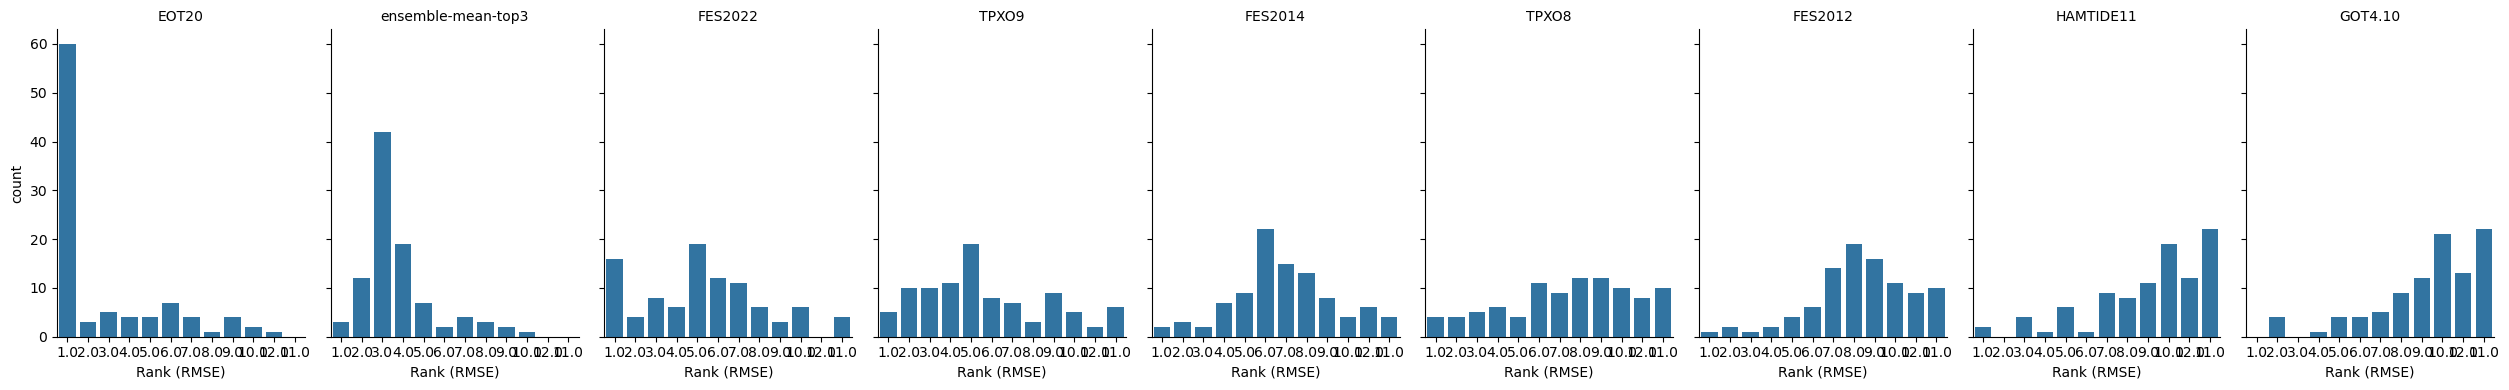

In [60]:
rank_counts = (
    accuracy_sites_df.groupby("site_name")
    .RMSE.rank(method="min")
    .groupby("tide_model")
    .value_counts()
    .rename_axis(["tide_model", "Rank (RMSE)"])
)

g = sns.FacetGrid(
    rank_counts.to_frame().reset_index(),
    col_order=[
        "EOT20",
        "ensemble-mean-top3",
        "FES2022",
        "TPXO9",
        "FES2014",
        "TPXO8",
        "FES2012",
        "HAMTIDE11",
        "GOT4.10",
    ],
    col="tide_model",
    aspect=0.7,
    height=4,
)
g.set_titles(col_template="{col_name}")
g.map(sns.barplot, "Rank (RMSE)", "count")

### Export tide validation plots

In [ ]:
# # Calculate tide range per site
# tide_range = (
#     tide_df_long.groupby("site_name")["tide_gauge"]
#     .apply(lambda x: np.abs(x).max())
#     .sort_values()
# )

# Select subset
# sites, limits, title = tide_range.loc[tide_range >= 2].index, 5, "Macrotidal sites"
# sites, limits, title = tide_range.loc[(tide_range >= 1) & (tide_range < 2)].index, 2, "Mesotidal sites"
# sites, limits, title = tide_range.loc[tide_range < 1].index, 1, "Microtidal sites"

# Optionally restrict to subset
site_filter = [
    # "DYDBY01",
    # "63090",
    # "59511",
    # "59510",
    # "61800",
    # "59690",
    # "61840",
    # "61600",
    # "58170",
    # "60780",
    # "60739",
    # "60590",
    # "63511",
    # "59980",
    # "60710",
    # "60730",
    "59850",
]
site_filter = most_disagrement.tolist()
# site_filter = ["Milner_Bay_Groote_Eylandt"]
sites, limits, title = site_filter, 3, "Problematic sites" 
models_to_plot = ['EOT20', 'FES2012', 'FES2014', 'GOT4.10', 'HAMTIDE11', 
                  'TPXO9', 'TPXO8', 'ensemble-mean-top3']

# Plot facetted
g = sns.FacetGrid(
     tide_df_long.query(f"(site_name in {sites}) & (tide_model in @models_to_plot)").reset_index(),
    col="tide_model",
    row="site_name",
    margin_titles=True,
    # xlim=(-limits, limits),
    # ylim=(-limits, limits),
)
g.fig.suptitle(title, size=20)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.map(sns.scatterplot, "tide_gauge", "tide_m", alpha=0.1, linewidth=0, s=3)
for a in g.axes.flat:
    a.plot([-limits, limits], [-limits, limits], "--", c="black")
g.savefig(f"{title.replace(' ', '')}.jpg")